# DR CRC Model: US Natural History Calibration
Sophie Wagner, sw3767@cumc.columbia.edu

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps  # https://csaps.readthedocs.io/en/latest/
import common_functions as func
import configs as c
import markov as m
import gof
import calibration_plots as p
from datetime import datetime
from calibration_interp import simulated_annealing as interp_anneal
from calibration_lin_log import simulated_annealing as lin_log_anneal

In [2]:
# Some aesthetic options
np.set_printoptions(
    suppress=True, linewidth=300, formatter={"float": "{: 0.9f}".format}
)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(layer, 1 - sum_of_columns)
    return matrix



def calculate_single_transition_prob_from_logistic(params):
    return func.get_tp(params, c.age_layers)


def initialize_params():
    # Logis parameters: base, increase, offset, spread
    params = np.zeros((len(c.points),4))
    params[0] = [0.005, 0.001, 50, 0.1] # Healthy to LR    
    params[1] = [0.015, 0.001, 50, 0.1] # LR to HR
    params[2] = [0.05, 0.001, 50, 0.1] # HR to uLoc
    params[3] = [0.45, 0.001, 50, 0.1] # uLoc to uReg
    params[4] = [0.50, 0.001, 50, 0.1] # uReg to uDis
    params[5] = [0.20, 0.001, 50, 0.1] # uLoc to dLoc
    params[6] = [0.60, 0.001, 50, 0.1] # uReg to dReg
    params[7] = [0.90, 0.001, 50, 0.1] # uDis to dDis

    return params


def constrain_params(params):
    params[0,-1] = max(params[0,-1],0.00001) # Not negative increase
    return params
    

def create_matrix(params=None):
    if params is None:
        params = initialize_params()

    matrix = np.zeros((len(c.age_layers), len(c.health_states), len(c.health_states)))
    for idx, (from_state, to_state) in enumerate(c.points):
        matrix[:, from_state, to_state] = func.probtoprob(params[idx,0]) # monthly

    # Start with logistic function for (0,1) transition healthy to lr
    matrix[:, 0, 1] = func.probtoprob(np.array(calculate_single_transition_prob_from_logistic(params[0])))
    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize 
    
    return params, matrix

def constrain_matrix(matrix):
    matrix = np.clip(matrix,0.0,0.6)
   
    # Progression Block
    matrix[:,0,1] = np.maximum(0.000001, matrix[:,0,1])  # not below 0
    matrix[:,1,2] = np.maximum(matrix[:,0,1], matrix[:,1,2]) 
    
    # Detection Block
    matrix[:,3,6] = np.maximum(0, matrix[:,3,6])  # not below 0
    matrix[:,4,7] = np.maximum(matrix[:,3,6], matrix[:,4,7])  # P[d_reg] > P[d_loc]
    matrix[:,5,8] = np.maximum(matrix[:,4,7], matrix[:,5,8])  # P[d_dis] > P[d_reg]
    
    return matrix


def add_acm(matrix):
    matrix[:,0,10] = c.acm_rate  # Healthy to ACM
    matrix[:,1:3,12] = c.acm_rate[:, np.newaxis] # Polyp to ACM
    matrix[:,3:6,13] = c.acm_rate[:, np.newaxis] # Undiagnosed to ACM
    matrix[:,6:9,11] = c.acm_rate[:, np.newaxis]  # Cancer to ACM
    matrix[:,9,9] = 1  # Stay in CSD
    matrix[:,10,10] = 1  # Stay in ACM
    matrix[:,11,11] = 1  # Stay in Cancer ACM
    matrix[:,12,12] = 1  # Stay in Polyp ACM
    matrix[:,13,13] = 1  # Stay in uCRC ACM

    return matrix 


def add_csd(matrix):
    matrix[:, 6, 9] = c.csd_rate[:, 0]
    matrix[:, 7, 9] = c.csd_rate[:, 1]
    matrix[:, 8, 9] = c.csd_rate[:, 2]
    return matrix

def interp_matrix(matrix):
    
    age_mids = np.arange(0, 65)  # Age midpoints for interpolation up to 85
    age_mids = np.append(age_mids, 100) # Add 100 to anchor the extrapolation
    all_ages = c.age_layers # Full range of age_layers
    interp_points = c.points[1:] # Exclude first transition from interpolation
  
    for (from_state, to_state) in interp_points: 
        """ Interpolate based on parameters up to age 85
            Anchor based on the mean of these parameter values
        """
        under_85 = matrix[:65, from_state, to_state]  # Extract transition probs up to age 85
        anchored = np.append(under_85, np.mean(under_85))  # Append mean to age 100
        tsmooth_spline = csaps(age_mids, anchored, smooth=.001)  
        matrix[:,from_state,to_state] = tsmooth_spline(all_ages).clip(0.000001, 0.6)

    return matrix


def step(params, matrix, step_size, num_adj=21):
    new_matrix = np.copy(matrix)
    new_params = np.copy(params)
    step_weights = [9/100] + [13/100]*7
    step_mat = np.random.choice(len(c.points), size=num_adj, replace=True, p=step_weights)
    step_age = np.random.choice(len(c.age_layers), size = num_adj, replace=True)

    for i in range(num_adj):
        # For first transition (logistic), sample logis params directly
        if step_mat[i] == 0:
            param_change = np.random.choice(params.shape[1])
            param_base = new_params[0,0] # base value
            # Sample using step_size and base value
            new_params[0,param_change] += np.random.uniform(low=-step_size*param_base, high=step_size*param_base)
            new_params = constrain_params(new_params)
            new_matrix[:,0,1] = calculate_single_transition_prob_from_logistic(new_params[0])
            new_matrix[:,0,1] = [func.probtoprob(tp) for tp in new_matrix[:,0,1]]

        # For all others, sample 1 value from a particular age group
        else:
            new_matrix[step_age[i], c.points[step_mat[i]][0], c.points[step_mat[i]][1]] += np.random.uniform(low=-step_size, high=step_size)
   
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = interp_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_params, new_matrix


def simulated_annealing(n_iterations, step_size, start_pmat=None, start_tmat=None, n_adj=7, verbose=False):

    if start_tmat is None or start_pmat is None:
        raise ValueError("Need both pmat and tmat")
    else:
        best_p = np.copy(start_pmat)
        best_t = np.copy(start_tmat)
    best_log = m.run_markov_new(best_t)
    best_eval = gof.objective(best_log,1)  # evaluate the initial point
    curr_p, curr_t, curr_eval = best_p, best_t, best_eval  # current working solution
    ticker = 0
    for i in range(n_iterations):  
        if ticker >= 10000: break

        # Run model 

        candidate_p, candidate_t = np.copy(curr_p), np.copy(curr_t)
        candidate_p, candidate_t = step(candidate_p, candidate_t, step_size, n_adj)
        candidate_log = m.run_markov_new(candidate_t)
        candidate_eval = gof.objective(candidate_log,i)  # Evaluate candidate point
 
        # Update "best" if better than candidate
        if candidate_eval < best_eval:
            ticker = 0
            best_p, best_t, best_eval = np.copy(candidate_p), np.copy(candidate_t), np.copy(candidate_eval) 
            best_log = m.run_markov_new(best_t)

        else: 
            ticker += 1

        # t = 10 / float(i+1)  # calculate temperature for current epoch
        t = 1 /(1+np.log(i+1))

        # Progress report
        if verbose and i%500==0:
            inc_log=best_log[3]
            total_dxd=np.sum(inc_log[6:9,:])/c.N 
            print(i, ": ", best_eval,"   CRC: ", round(total_dxd,5))
            if i%5000==0:
                transition_probs = p.extract_transition_probs(
                    best_t, c.health_states, c.desired_transitions
                )

                print(f"Progress report, i = {i}")
                p.print_trans_probs(transition_probs)
                print(f"Healthy to LR params: {best_p[0]}")
           
        # Check if we should update "curr"
        diff = candidate_eval - curr_eval  # difference between candidate and current point evaluation
        metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion        
        if diff < 0 or np.random.random() < metropolis:  # check if we should keep the new point
            curr_p, curr_t, curr_eval = np.copy(candidate_p), np.copy(candidate_t), np.copy(candidate_eval) # store the new current point
        
    print(best_eval)
    return best_p, best_t

## Run Calibration

In [4]:
pmat, tmat = create_matrix()
result = simulated_annealing(
    20, 0.01, start_pmat=pmat, start_tmat=tmat, n_adj=15, verbose=True
)

0 :  166406.02559828176    CRC:  0.05436
Progress report, i = 0
Monthly transition probs
healthy to LR_polyp: 0.00043
LR_polyp to HR_polyp: 0.00126
HR_polyp to u_CRC_loc: 0.00427
u_CRC_loc to u_CRC_reg: 0.04860
u_CRC_reg to u_CRC_dis: 0.05613
u_CRC_loc to d_CRC_loc: 0.01842
u_CRC_reg to d_CRC_reg: 0.07352
u_CRC_dis to d_CRC_dis: 0.17460

Annual transition probs
healthy to LR_polyp: 0.00512
LR_polyp to HR_polyp: 0.01500
HR_polyp to u_CRC_loc: 0.05000
u_CRC_loc to u_CRC_reg: 0.45000
u_CRC_reg to u_CRC_dis: 0.50000
u_CRC_loc to d_CRC_loc: 0.20000
u_CRC_reg to d_CRC_reg: 0.60000
u_CRC_dis to d_CRC_dis: 0.90000
Healthy to LR params: [ 0.005000000  0.001000000  50.000000000  0.100000000]


C:\Users\sophi\AppData\Local\Temp\ipykernel_13084\1410062934.py:187: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion


80112.6444557487


: 

In [5]:
#result = interp_anneal(20, 0.01, start_tmat=tmat, n_adj=15, verbose=True)
result = lin_log_anneal(n_iterations= 5000, step_size=0.01, n_adj=15, verbose=True)

Params before adjustment: [[ 0.005000000  0.001000000  30.000000000  0.100000000]
 [ 0.015000000  0.001000000  30.000000000  0.100000000]
 [ 0.050000000  0.001000000  30.000000000  0.100000000]
 [ 0.450000000  0.001000000  30.000000000  0.100000000]
 [ 0.500000000  0.001000000  30.000000000  0.100000000]
 [ 0.200000000  0.001000000  30.000000000  0.100000000]
 [ 0.600000000  0.001000000  30.000000000  0.100000000]
 [ 0.900000000  0.001000000  30.000000000  0.100000000]]
Params after adjustment: [[ 0.000417625  0.000083372  30.000000000  0.100000000]
 [ 0.001258677  0.000083372  30.000000000  0.100000000]
 [ 0.004265319  0.000083372  30.000000000  0.100000000]
 [ 0.048599101  0.000083372  30.000000000  0.100000000]
 [ 0.056125687  0.000083372  30.000000000  0.100000000]
 [ 0.018423470  0.000083372  30.000000000  0.100000000]
 [ 0.073515128  0.000083372  30.000000000  0.100000000]
 [ 0.174595815  0.000083372  30.000000000  0.100000000]]
(1, 2): [ 0.001258677  0.003759824  0.005427255  0.

In [11]:
# Generate the current timestamp in the format YYYYMMDD_HHMMSS
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

curr_pmat, curr_tmat = result[0].copy(), result[1].copy()
curr_log = m.run_markov_new(curr_tmat)
log_adj, log_prev, log_pop, log_inc = curr_log

# Save the numpy arrays with the timestamp in the filenames
np.save(f"../out/tmats/tmat_us_{timestamp}.npy", curr_tmat)
np.save(f"../out/logs/log_us_ainc_{timestamp}.npy", log_adj)
np.save(f"../out/logs/log_us_aprev_{timestamp}.npy", log_prev)
np.save(f"../out/logs/log_us_uprev_{timestamp}.npy", log_pop)
np.save(f"../out/logs/log_us_uinc_{timestamp}.npy", log_inc)

### Print transition probabilities

In [47]:
# Extract transition probabilities
transition_probs = p.extract_transition_probs(
    curr_tmat, c.health_states, c.desired_transitions
)
p.print_trans_probs(transition_probs)

Monthly transition probs
healthy to LR_polyp: 0.00042
LR_polyp to HR_polyp: 0.00108
HR_polyp to u_CRC_loc: 0.00422
u_CRC_loc to u_CRC_reg: 0.04589
u_CRC_reg to u_CRC_dis: 0.05489
u_CRC_loc to d_CRC_loc: 0.02026
u_CRC_reg to d_CRC_reg: 0.07228
u_CRC_dis to d_CRC_dis: 0.17457

Annual transition probs
healthy to LR_polyp: 0.00504
LR_polyp to HR_polyp: 0.01285
HR_polyp to u_CRC_loc: 0.04949
u_CRC_loc to u_CRC_reg: 0.43094
u_CRC_reg to u_CRC_dis: 0.49206
u_CRC_loc to d_CRC_loc: 0.21776
u_CRC_reg to d_CRC_reg: 0.59356
u_CRC_dis to d_CRC_dis: 0.89996


Plot transition probabilities

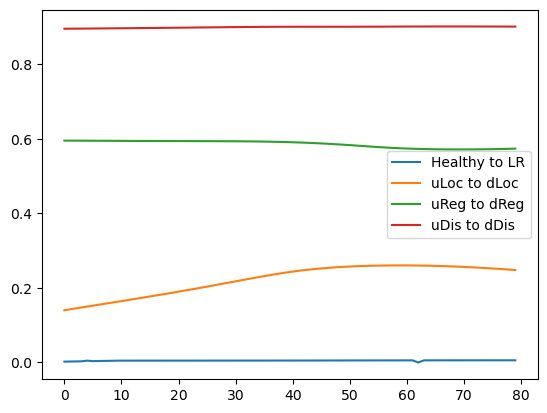

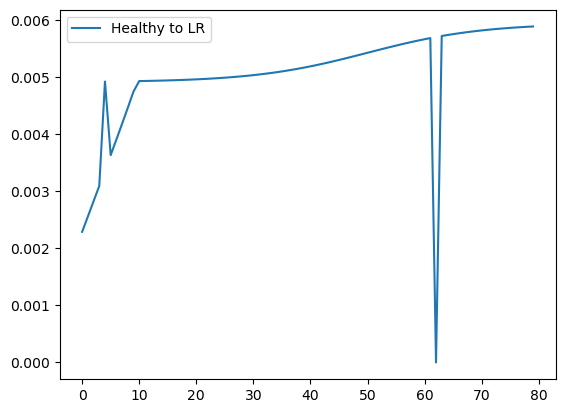

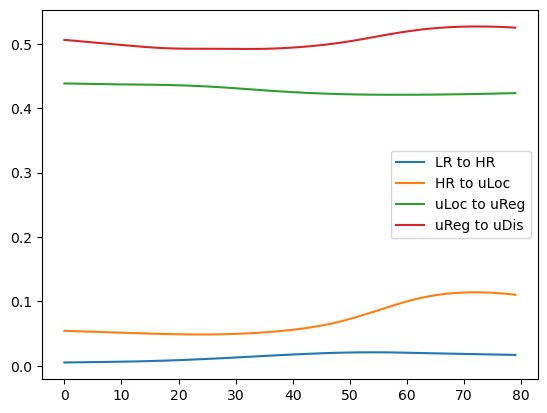

In [48]:
p.plot_tps(curr_tmat)

### Compare model and SEER incidence

In [ ]:
p.plot_vs_seer(curr_log, c.seer_inc)
p.plot_vs_seer_total(curr_log, c.seer_inc)

### Inspect prevalences by health state